In [31]:
import pandas as pd
import wrangle as wr
import summaries as s
from importlib import reload
import numpy as np

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format

### Questions:
1. Is there any significant difference in sales by the __day of the week__?
2. Is there any significant difference in sales by the __week__?
3. Is there any significant difference in sales by the __month__?
4. Is there any significant difference in sales by the __quarter__?

__Let's look deeper into pandemic__ - not doing, Chris picked it up

5. Daily/weekly/monthle changes in the sales


#### Statistical tests for the values that visualy seem to be significant or there is a doubt 

In [5]:
reload(wr)

<module 'wrangle' from '/Users/nadina/codeup-data-science/cisco-time-series-analysis/nadia_docs/wrangle.py'>

There is missing data for the 2017. I create sets of data that include:

1) all data 2014-2016:2018-2021 

2) starting from 2018 only

In [37]:
# clean data
df = wr.get_clean_data(start2018=True)
# train/test split
train, test = wr.split_data(df)
# time series variable
ts = train.purchase_amount

In [73]:
# order for graphs
months =['January', 'February', 'March', 'April', 'May', 
         'June', 'July', 'August', 'September', 'October', 'November', 'December']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [2]:
#df.isnull().sum()

In [10]:
df.head(1)

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,shipped_date,order_date_copy,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,,,
2014-05-06,Carroll Independent School District,K-12,Southlake,NaN,NaN,76092,2.00,"4,328.10",PA2,2014-06-17,2014-05-06,2014,2,May,Tuesday,5,19,1,126,"8,656.20"


### Q1. Is there any significant difference in sales by the day of the week?

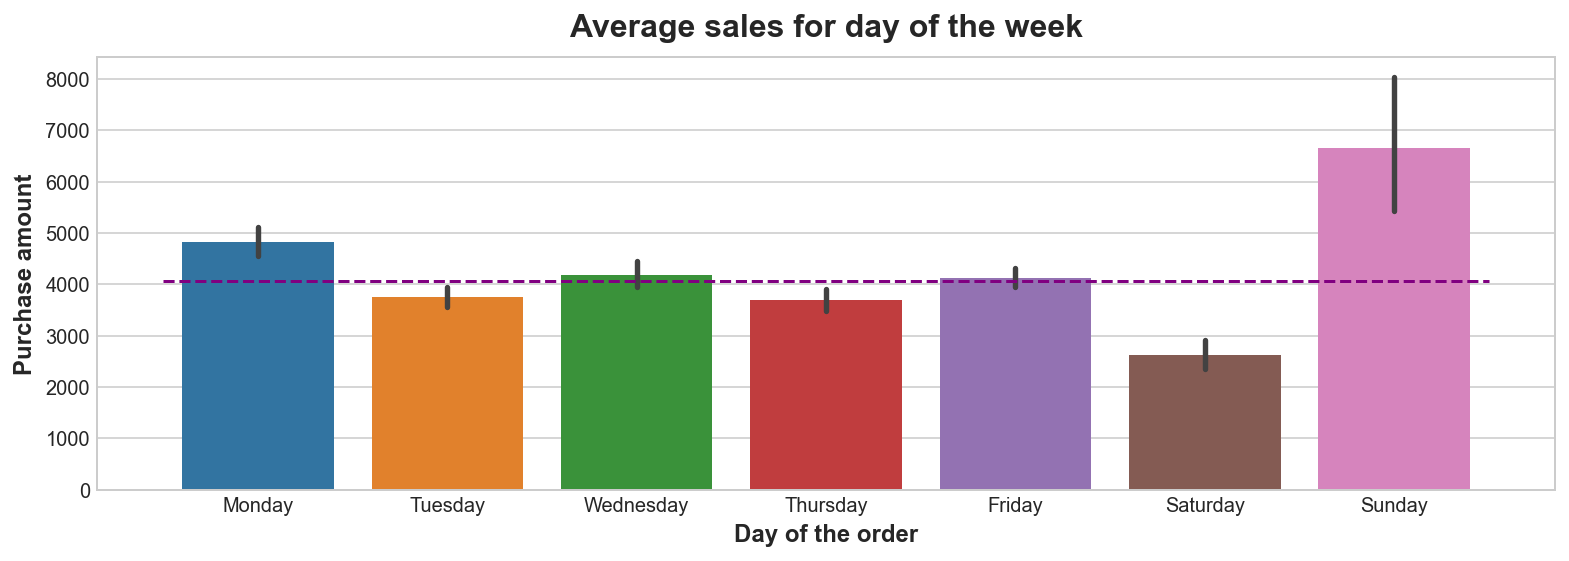

In [74]:
ax = sns.barplot(data = train, x='day_name', y='purchase_amount', order=days)
plt.xlabel('Day of the order')
plt.ylabel('Purchase amount')
x_left, x_right = ax.get_xlim()
ax.hlines(train.purchase_amount.mean(), x_left, x_right, ls='--', color='purple')
plt.title('Average sales for day of the week')
plt.show()

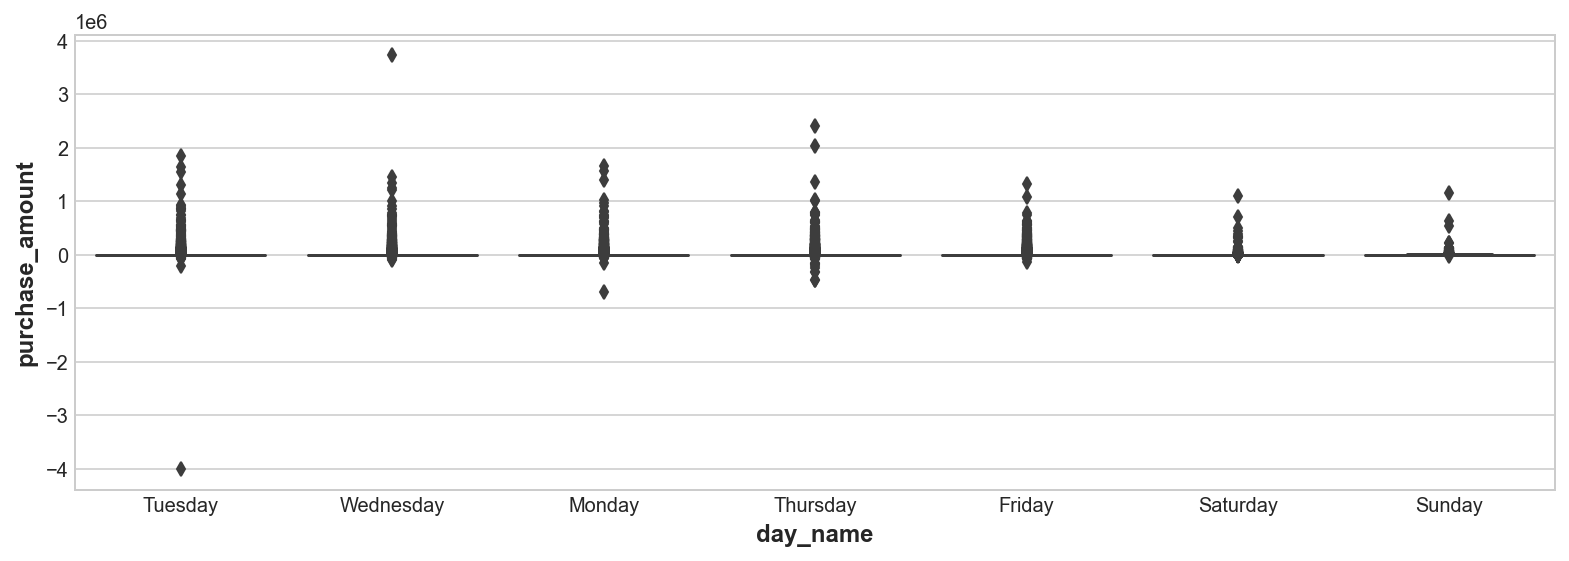

In [12]:
sns.boxplot(data = train, x='day_name', y='purchase_amount');

#### Takeaway:
There is an unexpected peak of average `purchase_amount` on Sunday. Since the goverment insitutions don't work on Sunday, it might be when resellers put their orders right before Monday. The graph also shows big variance in the values on Sunday. I'm going to create sets for each day to run stat tests.

In [40]:
mon = train[train.day_name == 'Monday']
tue = train[train.day_name == 'Tuesday']
wed = train[train.day_name == 'Wednesday']
thu = train[train.day_name == 'Thursday']
fri = train[train.day_name == 'Friday']
sat = train[train.day_name == 'Saturday']
sun = train[train.day_name == 'Sunday']

#### Mon-Fri seem to be almost equal, let's run stat tests

$H_0:$ There is a significant difference in means of purchase amount during work days (Mon-Fri)

$H_a:$ There is no significant difference in means of purchase amount during work days (Mon-Fri)

*__Step 1:__* check if the variances are equal to decide which stat test to use.

If Levene test returns p-value < 0.5 we use Kruskal Wallis test, otherwise Anova test

In [28]:
stats.levene(mon.purchase_amount, tue.purchase_amount, wed.purchase_amount, thu.purchase_amount, fri.purchase_amount)

LeveneResult(statistic=4.1890684532606794, pvalue=0.002155805172080757)

In [30]:
stats.kruskal(mon.purchase_amount, tue.purchase_amount, wed.purchase_amount, thu.purchase_amount, fri.purchase_amount)

KruskalResult(statistic=828.5863477726896, pvalue=4.933049617649118e-178)

Now let's run 1 sample t-test for every set

In [87]:
days_of_week = {'Monday':mon, 'Tuesday':tue, 'Wednesday':wed, 'Thursday':thu, 
                'Friday':fri, 'Saturday':sat, 'Sunday':sun}
ttest_results_days = pd.DataFrame(columns=['Day', 'T-value', 'P-value'])
for day in days_of_week:
    sale = days_of_week[day]['purchase_amount']
    t, p = stats.ttest_1samp(sale, train.purchase_amount.mean())
    ttest_results_days.loc[len(ttest_results_days)] = [day, t, p]
ttest_results_days.set_index('Day', inplace=True)

In [88]:
ttest_results_days

,T-value,P-value
Day,,
Monday,5.61,0.00
Tuesday,-2.92,0.00
Wednesday,0.88,0.38
Thursday,-3.37,0.00
Friday,0.74,0.46
Saturday,-9.17,0.00
Sunday,3.85,0.00


Monday, Tuesday, Thursday, Saturday, Sunday are significant

### 2. Is there any significant difference in sales by the week?

In [44]:
train.week.min(), train.week.max()

(1, 53)

In [85]:
ttest_results_weeks = pd.DataFrame(columns=['Week', 'T-value', 'P-value'])
for i in range(1, 53):
    week = train[train.week == i]['purchase_amount']
    t, p = stats.ttest_1samp(week, train.purchase_amount.mean())
    ttest_results_weeks.loc[len(ttest_results_weeks)] = [i, t, p]
ttest_results_weeks.set_index('Week', inplace=True)

In [67]:
#train.head()

In [86]:
ttest_results_weeks

,T-value,P-value
Week,,
1.00,3.93,0.00
2.00,-11.97,0.00
3.00,-4.49,0.00
4.00,6.03,0.00
5.00,-0.48,0.63
6.00,-6.08,0.00
7.00,-2.58,0.01
8.00,1.09,0.28
9.00,2.22,0.03


#### Takeaways:
- Majority of weeks show a significant difference in means of purchase amount compared to the population. 

### 3. Is there any significant difference in sales by the month?

In [69]:
train.head(1)

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,shipped_date,order_date_copy,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,,,
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,78370,16.00,283.25,173494,2018-01-11,2018-01-02,2018,1,January,Tuesday,1,1,1,2,"4,532.00"


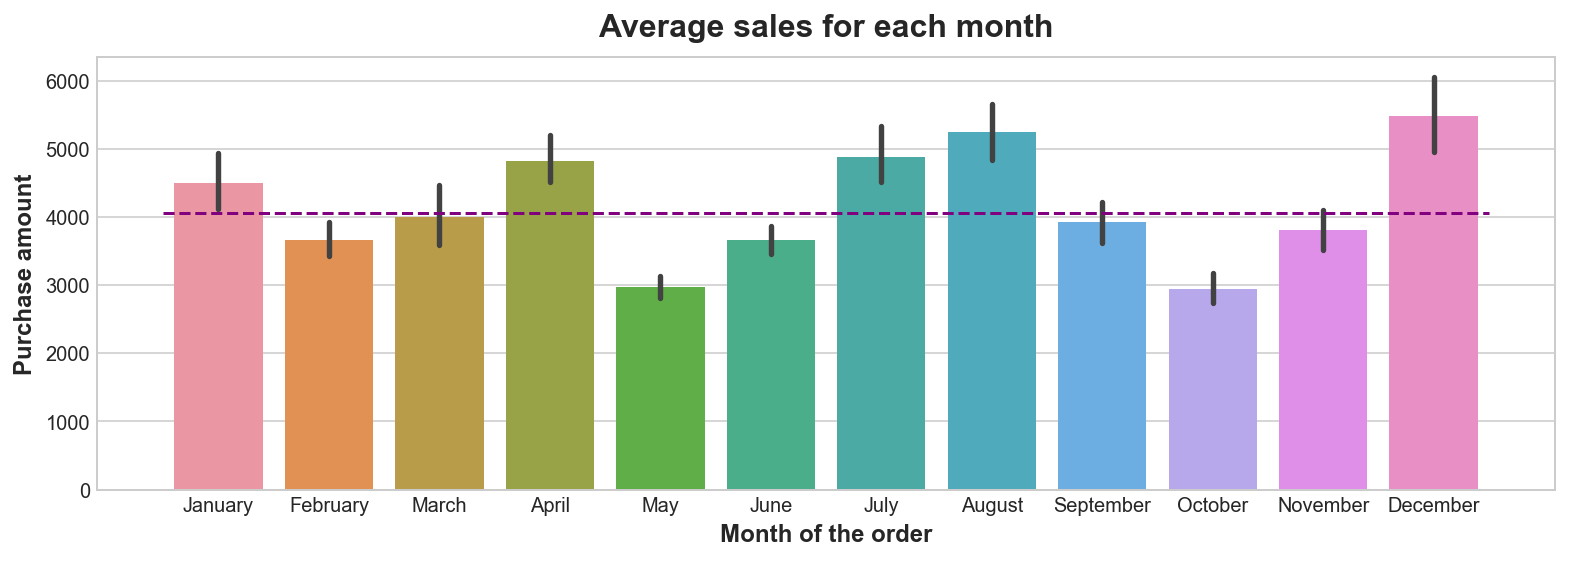

In [71]:
ax = sns.barplot(data=train, x='month_name', y='purchase_amount')
plt.xlabel('Month of the order')
plt.ylabel('Purchase amount')
x_left, x_right = ax.get_xlim()
ax.hlines(train.purchase_amount.mean(), x_left, x_right, ls='--', color='purple')
plt.title('Average sales for each month')
plt.show()

In [89]:
ttest_results_months = pd.DataFrame(columns=['Month', 'T-value', 'P-value'])
for m in months:
    month = train[train.month_name == m]['purchase_amount']
    t, p = stats.ttest_1samp(month, train.purchase_amount.mean())
    ttest_results_months.loc[len(ttest_results_months)] = [m, t, p]
ttest_results_months.set_index('Month', inplace=True)

In [90]:
ttest_results_months

,T-value,P-value
Month,,
January,2.05,0.04
February,-3.20,0.00
March,-0.30,0.76
April,4.34,0.00
May,-12.84,0.00
June,-3.70,0.00
July,3.82,0.00
August,5.83,0.00
September,-0.92,0.36


#### Takeaways:
- Some months are significantly different in sales
- May and October are the months with the lowest sales
- March has almost the same results as average sales, but there was peak in sales on March, 2020 when pandemic just started, it might happened that March is typically low on sales, too

### 4. Is there any significant difference in sales by the quarter?

In [ ]:
train.sample(frac=0.5).purchase_amount.plot.barh(y=train.quarter, width=0.5)

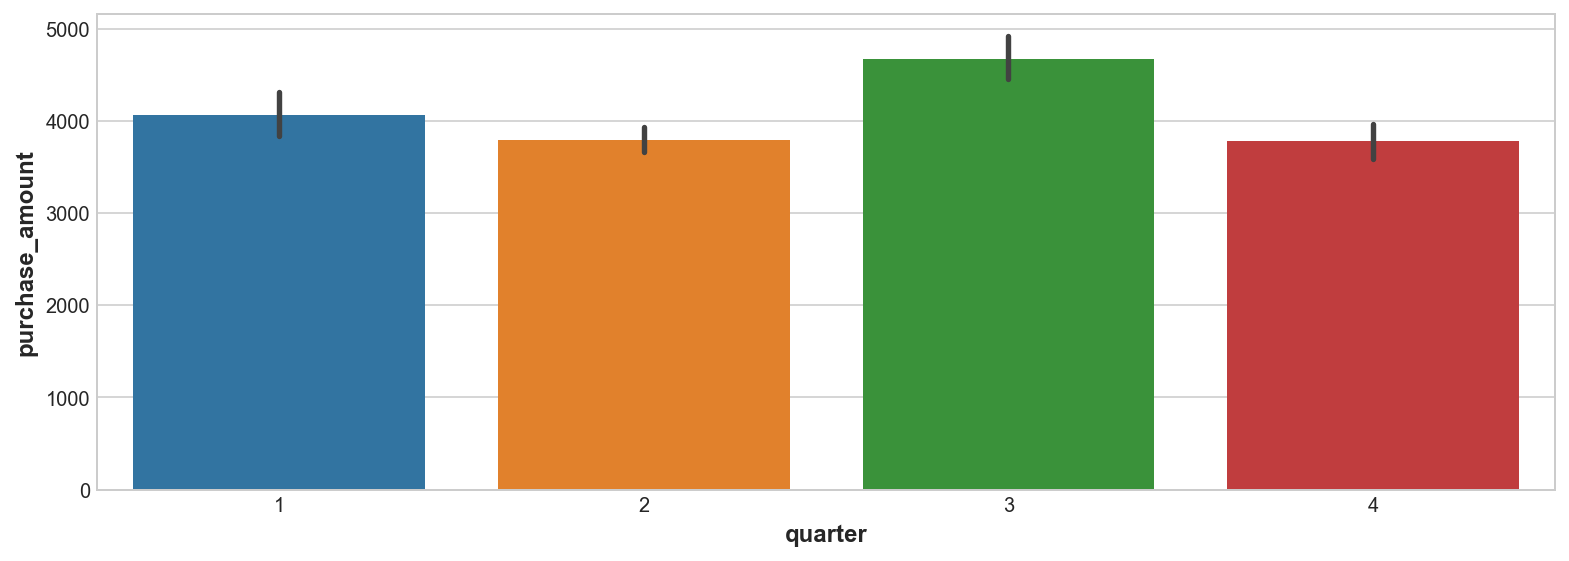

In [102]:
# Plot the crashes where alcohol was involved
#sns.set_color_codes("muted")
ax = sns.barplot(x="quarter", y="purchase_amount", data=train)


In [109]:
ttest_results_quarters = pd.DataFrame(columns=['Quarter', 'T-value', 'P-value'])
for i in range(1, 5):
    q = train[train.quarter == i]['purchase_amount']
    t, p = stats.ttest_1samp(q, train.purchase_amount.mean())
    ttest_results_quarters.loc[len(ttest_results_quarters)] = [i, t, p]
ttest_results_quarters.set_index('Quarter', inplace=True)

In [110]:
ttest_results_quarters

,T-value,P-value
Quarter,,
1.00,0.07,0.94
2.00,-3.74,0.00
3.00,5.27,0.00
4.00,-2.82,0.00


In [120]:
ts.loc['2020'].resample('D').sum()

order_date
2020-01-02   578,379.43
2020-01-03   113,620.72
2020-01-04         0.00
2020-01-05         0.00
2020-01-06   402,313.01
                ...    
2020-12-27         0.00
2020-12-28    73,159.87
2020-12-29    28,375.90
2020-12-30   326,815.97
2020-12-31   423,025.69
Freq: D, Name: purchase_amount, Length: 365, dtype: float64

In [165]:
#train.loc['2020-01-02']

In [123]:
reload(s)

<module 'summaries' from '/Users/nadina/codeup-data-science/cisco-time-series-analysis/nadia_docs/summaries.py'>

In [134]:
orders_summary = s.get_summary_orders_df(train)
sales_summary = s.get_summary_df(train)

In [128]:
orders_summary.loc['2020-01-02'].sort_values(by='order_quantity', ascending=False)

,customer_name,customer_type,customer_city,reseller_name,shipped_date,order_quantity
order_date,,,,,,
2020-01-02,Texas Health and Human Services Commission,State Agency,Austin,"Netsync Network Solutions, Inc.",2020-02-04,"4,633,095.72"
2020-01-02,Early Independent School District,K-12,Early,"Insight Public Sector, Inc.",2020-01-06,"22,525.77"
2020-01-02,Cy-Fair Volunteer Fire Department,Local Government,Houston,CDW Government LLC,2020-02-27,117.00
2020-01-02,Port of Houston Authority,Local Government,Houston,"Netsync Network Solutions, Inc.",2020-02-11,106.00
2020-01-02,Harris County,Local Government,Houston,CDW Government LLC,2020-02-11,67.00
2020-01-02,Texas A&M University System,Higher Ed,College Station,"Netsync Network Solutions, Inc.",2020-01-11,36.00
2020-01-02,Port of Houston Authority,Local Government,Houston,"Netsync Network Solutions, Inc.",2020-01-11,20.00
2020-01-02,Teacher Retirement System of Texas,State Agency,Austin,"SHI Government Solutions, Inc.",2020-01-06,10.00
2020-01-02,Teacher Retirement System of Texas,State Agency,Austin,"SHI Government Solutions, Inc.",2020-01-03,10.00


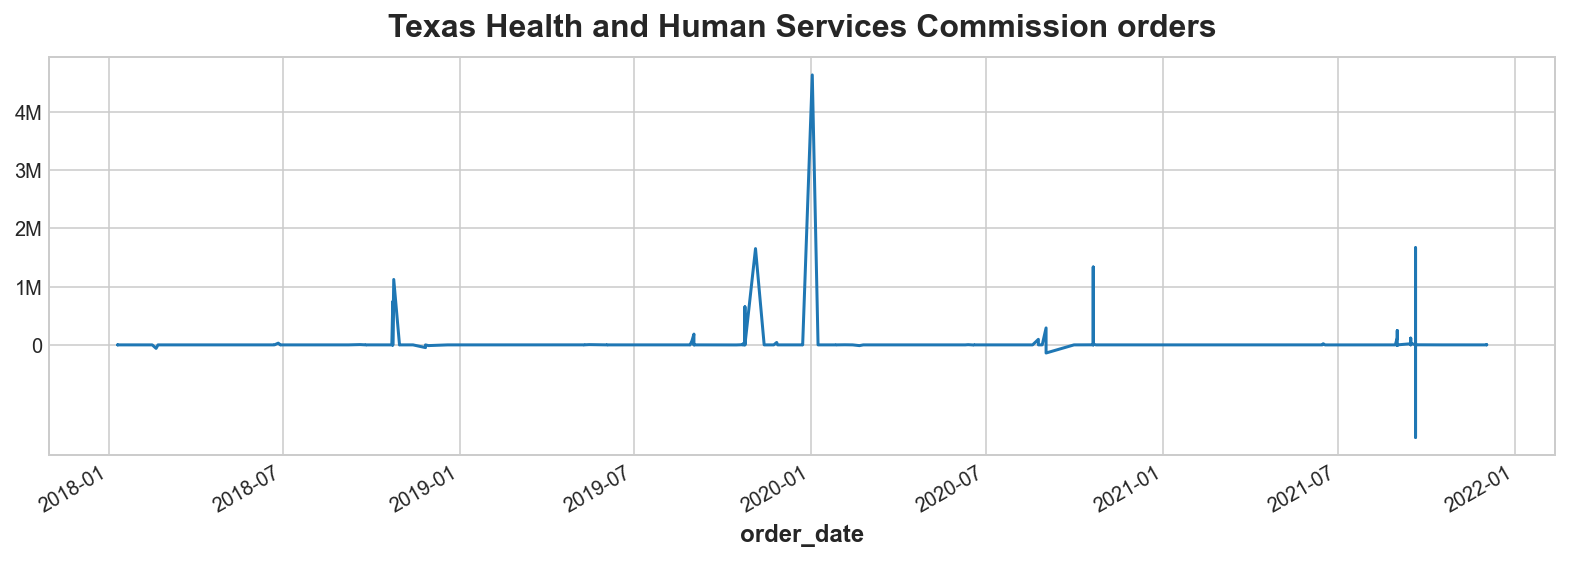

In [133]:
ax = orders_summary[orders_summary.customer_name == 'Texas Health and Human Services Commission'].order_quantity.plot()
plt.title('Texas Health and Human Services Commission orders')
ax.set(yticks=[0, 1_000_000, 2_000_000, 3_000_000, 4_000_000])
ax.set(yticklabels=['0', '1M', '2M', '3M', '4M'])
plt.show()

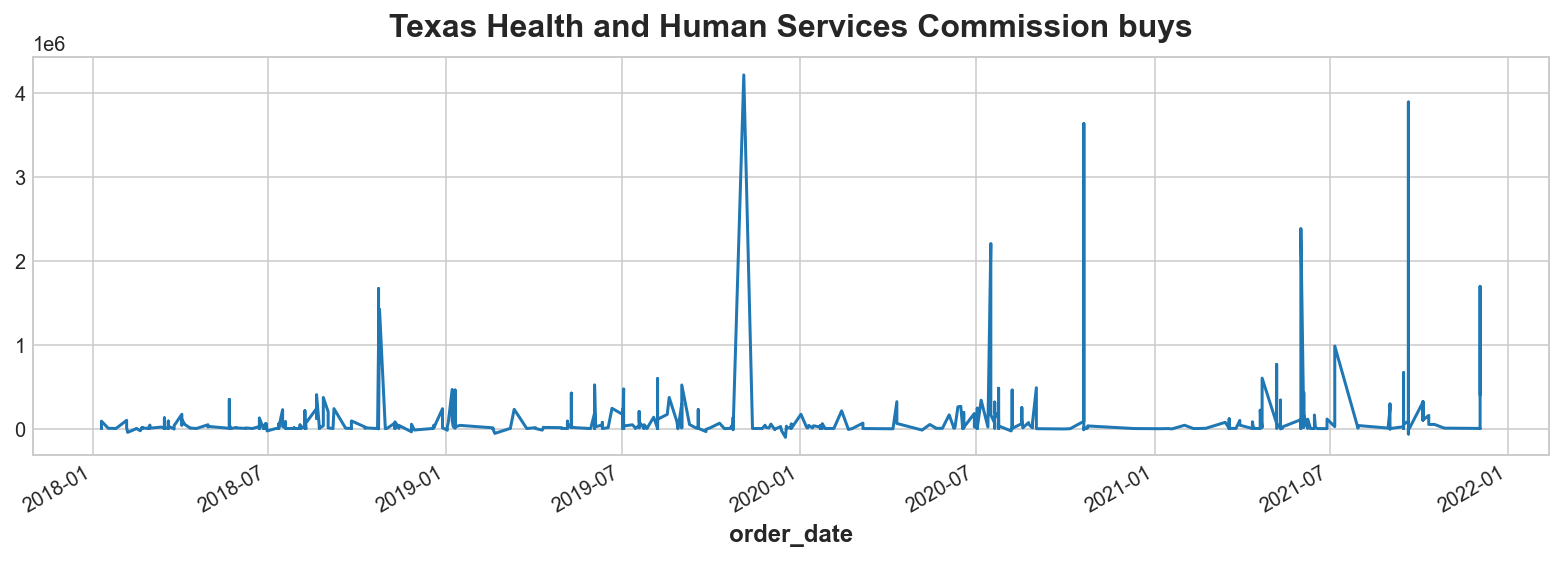

In [143]:
ax = sales_summary[sales_summary.customer_name == 'Texas Health and Human Services Commission'].purchase_amount.plot()
plt.title('Texas Health and Human Services Commission buys')
#ax.set(yticks=[0, 1_000_000, 2_000_000, 3_000_000, 4_000_000])
#ax.set(yticklabels=['0', '1M', '2M', '3M', '4M'])
plt.show()

In [141]:
#sales_summary

In [168]:
thhsc = pd.concat([
    orders_summary[orders_summary.customer_name == 'Texas Health and Human Services Commission'],
    sales_summary[sales_summary.customer_name == 'Texas Health and Human Services Commission'].purchase_amount
],axis=1)

Picture to add to Chris's order spike on Jan, 2 2020

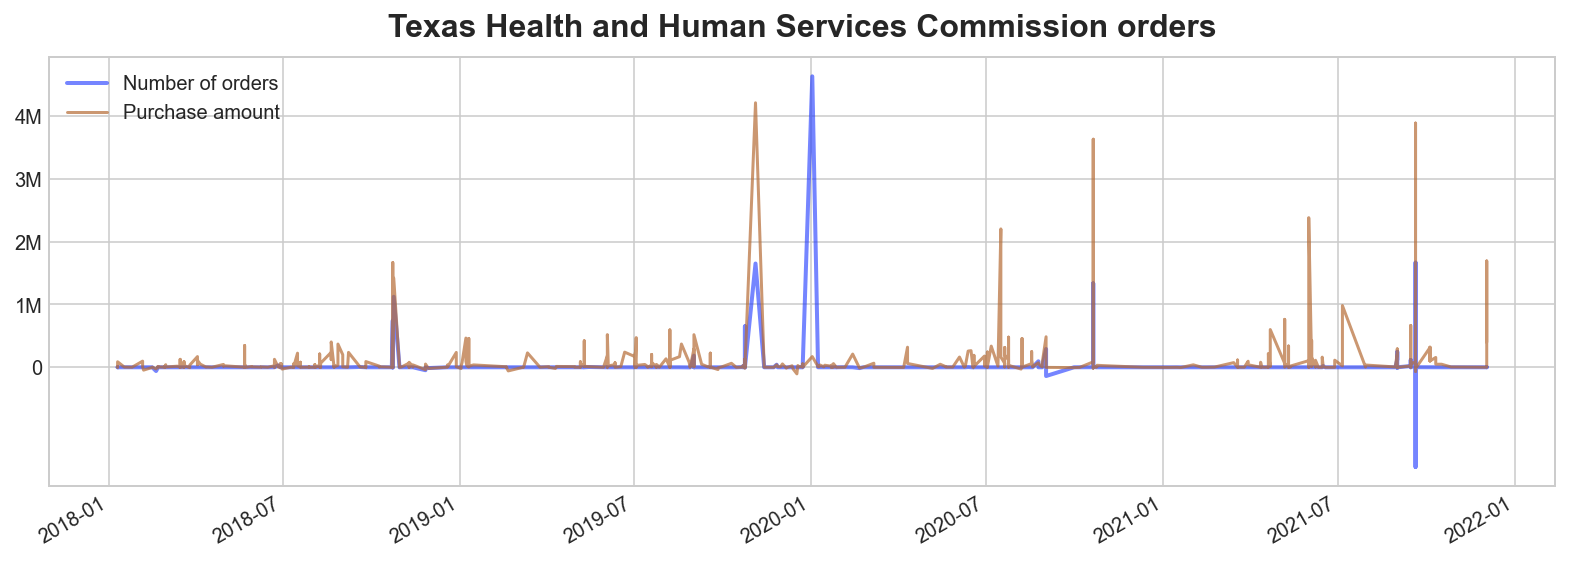

In [188]:
#ax, _ = plt.subplots(figsize=(18,6))
ax = thhsc.order_quantity.plot(label='Number of orders', lw=2, c='#1a34ff', alpha=0.6)
ax = thhsc.purchase_amount.plot(label='Purchase amount', lw=1.5, c='#b56b35', alpha=0.7)
plt.title('Texas Health and Human Services Commission orders')
ax.set(yticks=[0, 1_000_000, 2_000_000, 3_000_000, 4_000_000])
ax.set(yticklabels=['0', '1M', '2M', '3M', '4M'])
ax.set(xlabel=None)
plt.legend()
plt.show()

In [170]:
thhsc.order_quantity.sum()

10644361.628

In [171]:
thhsc.purchase_amount.sum()

60222875.79000001

Monthly changes in sales

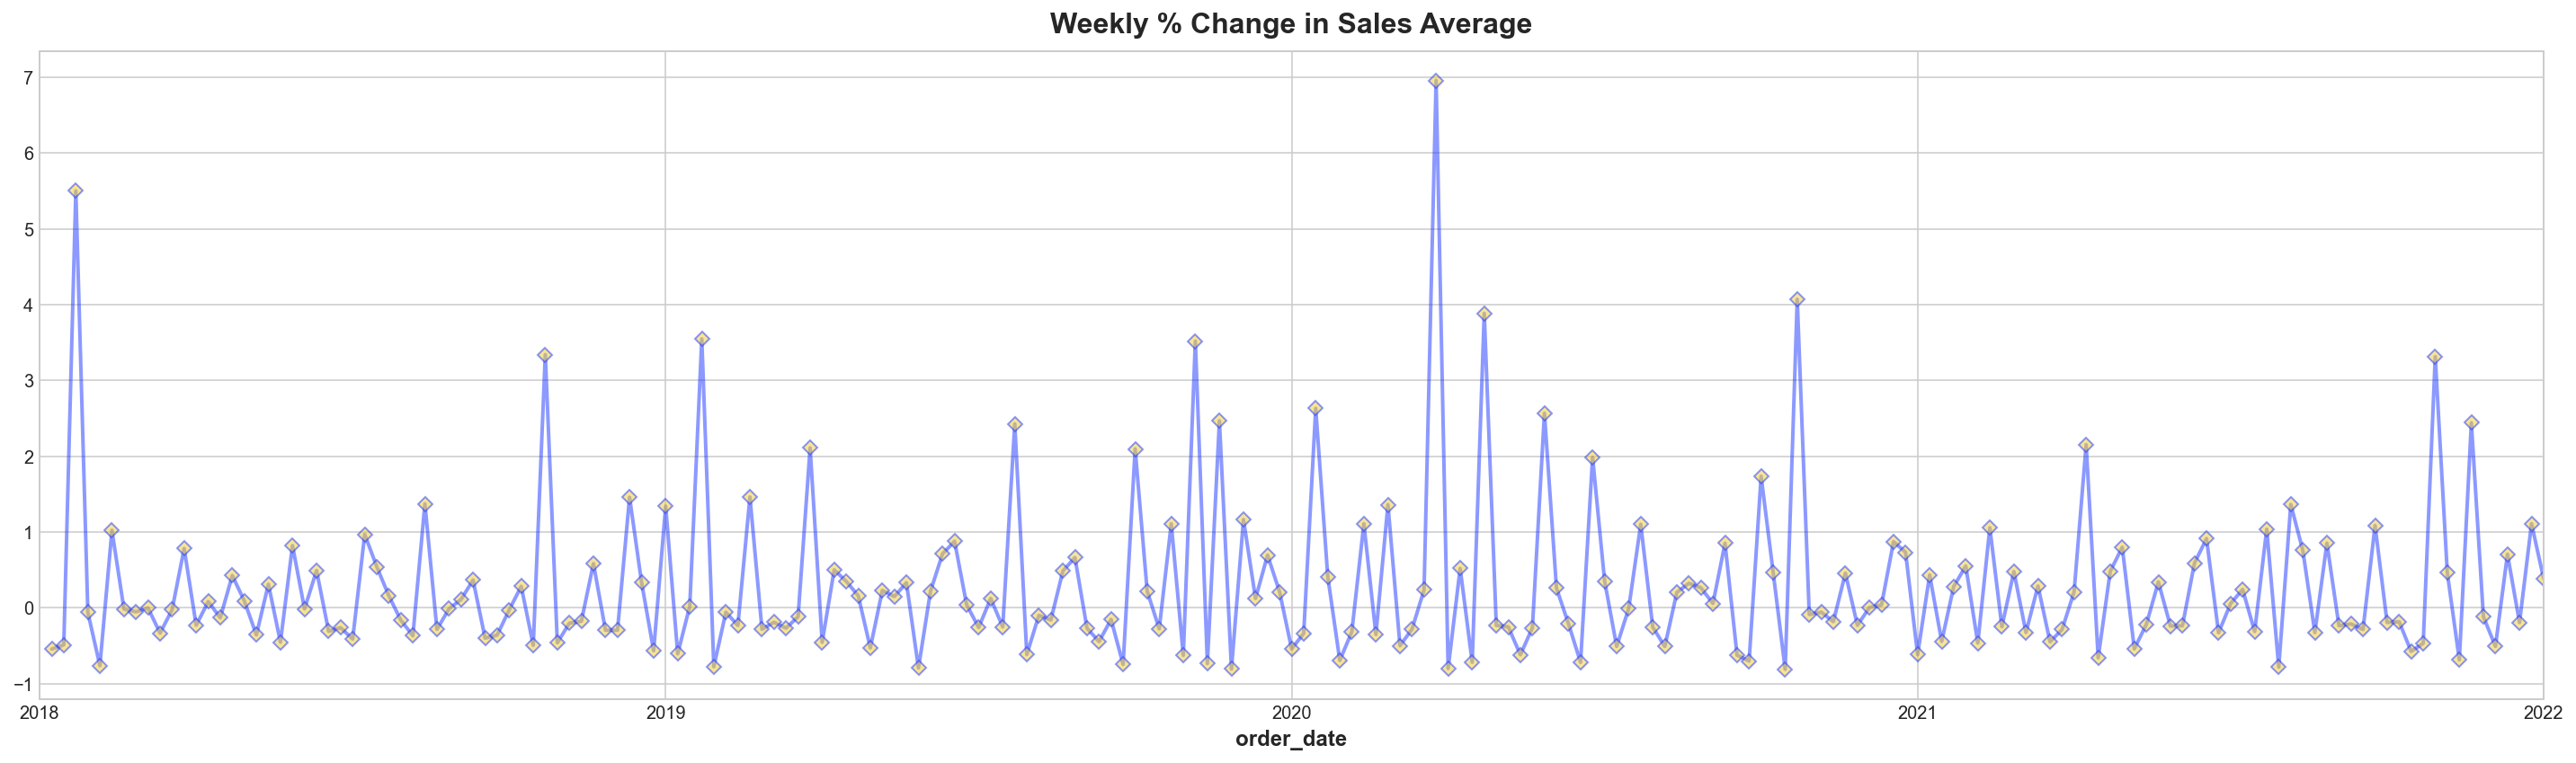

In [176]:
y_week = ts.resample('W').mean()
plt.figure(figsize = (20, 6))
(y_week.diff() / y_week.shift()).plot(alpha=.5, lw=2, c='#1a34ff', 
                                      marker='D', mfc='#f2cb30', title='Weekly % Change in Sales Average');

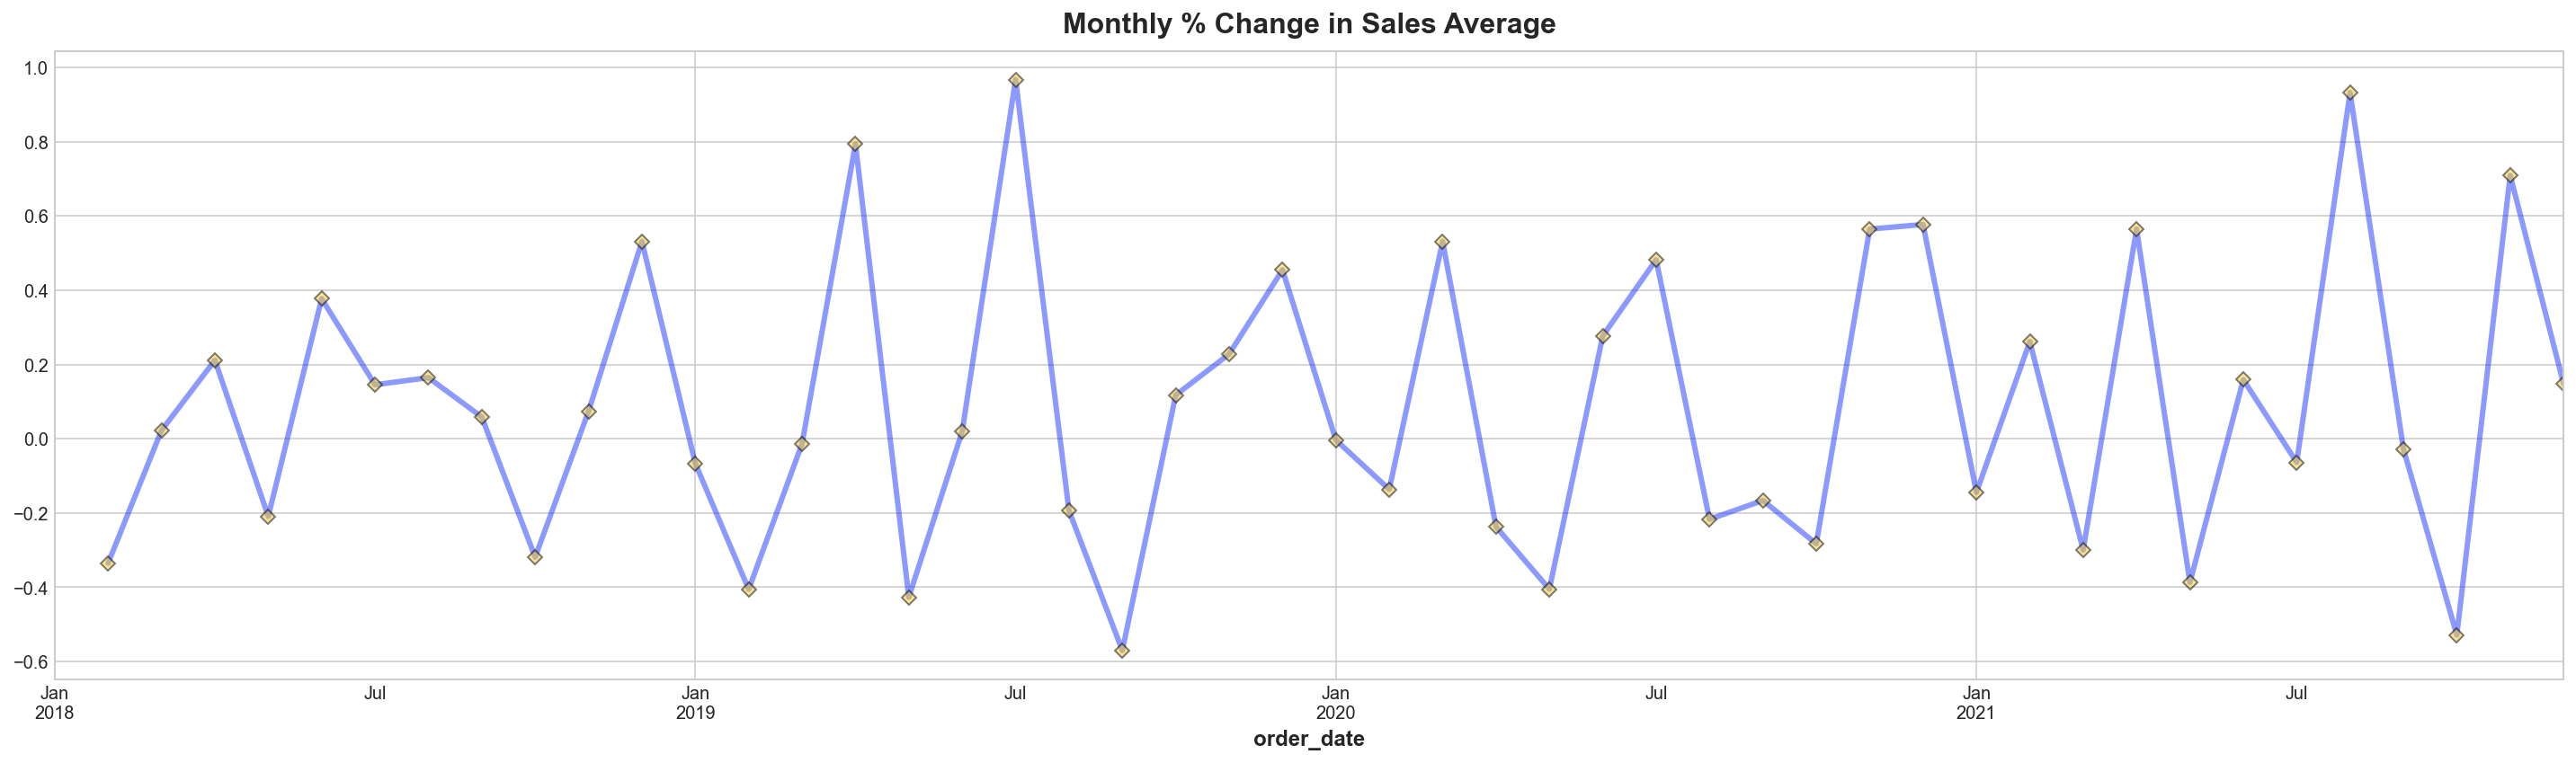

In [175]:
y_month = ts.resample('M').mean()
plt.figure(figsize = (20, 6))
(y_month.diff() / y_month.shift()).plot(alpha=.5, lw=3, c='#1a34ff', 
                                      marker='D', mfc='#f2cb30',mec='black', title='Monthly % Change in Sales Average');

Now the same but with the sum, not average

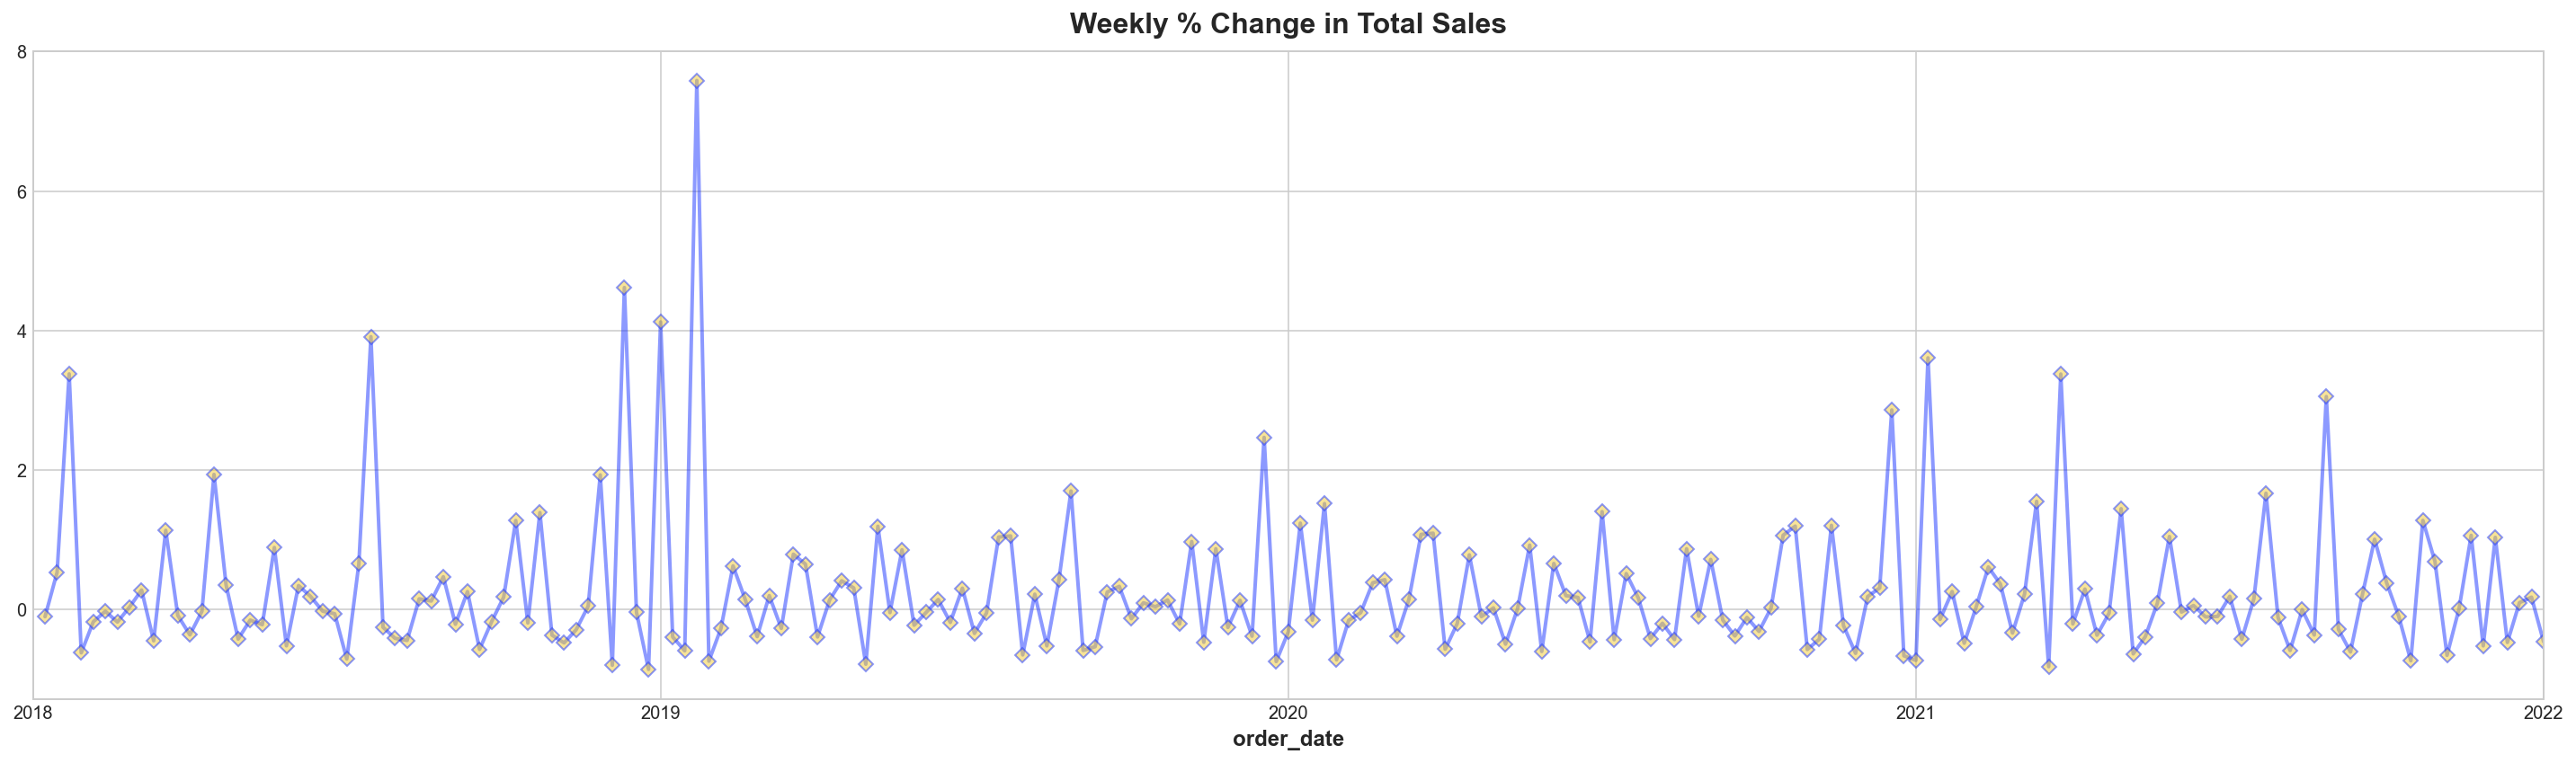

In [179]:
y_week = ts.resample('W').sum()
plt.figure(figsize = (20, 6))
(y_week.diff() / y_week.shift()).plot(alpha=.5, lw=2, c='#1a34ff', 
                                      marker='D', mfc='#f2cb30', title='Weekly % Change in Total Sales');

Is there any significant change in monthly sales percentage in our data?

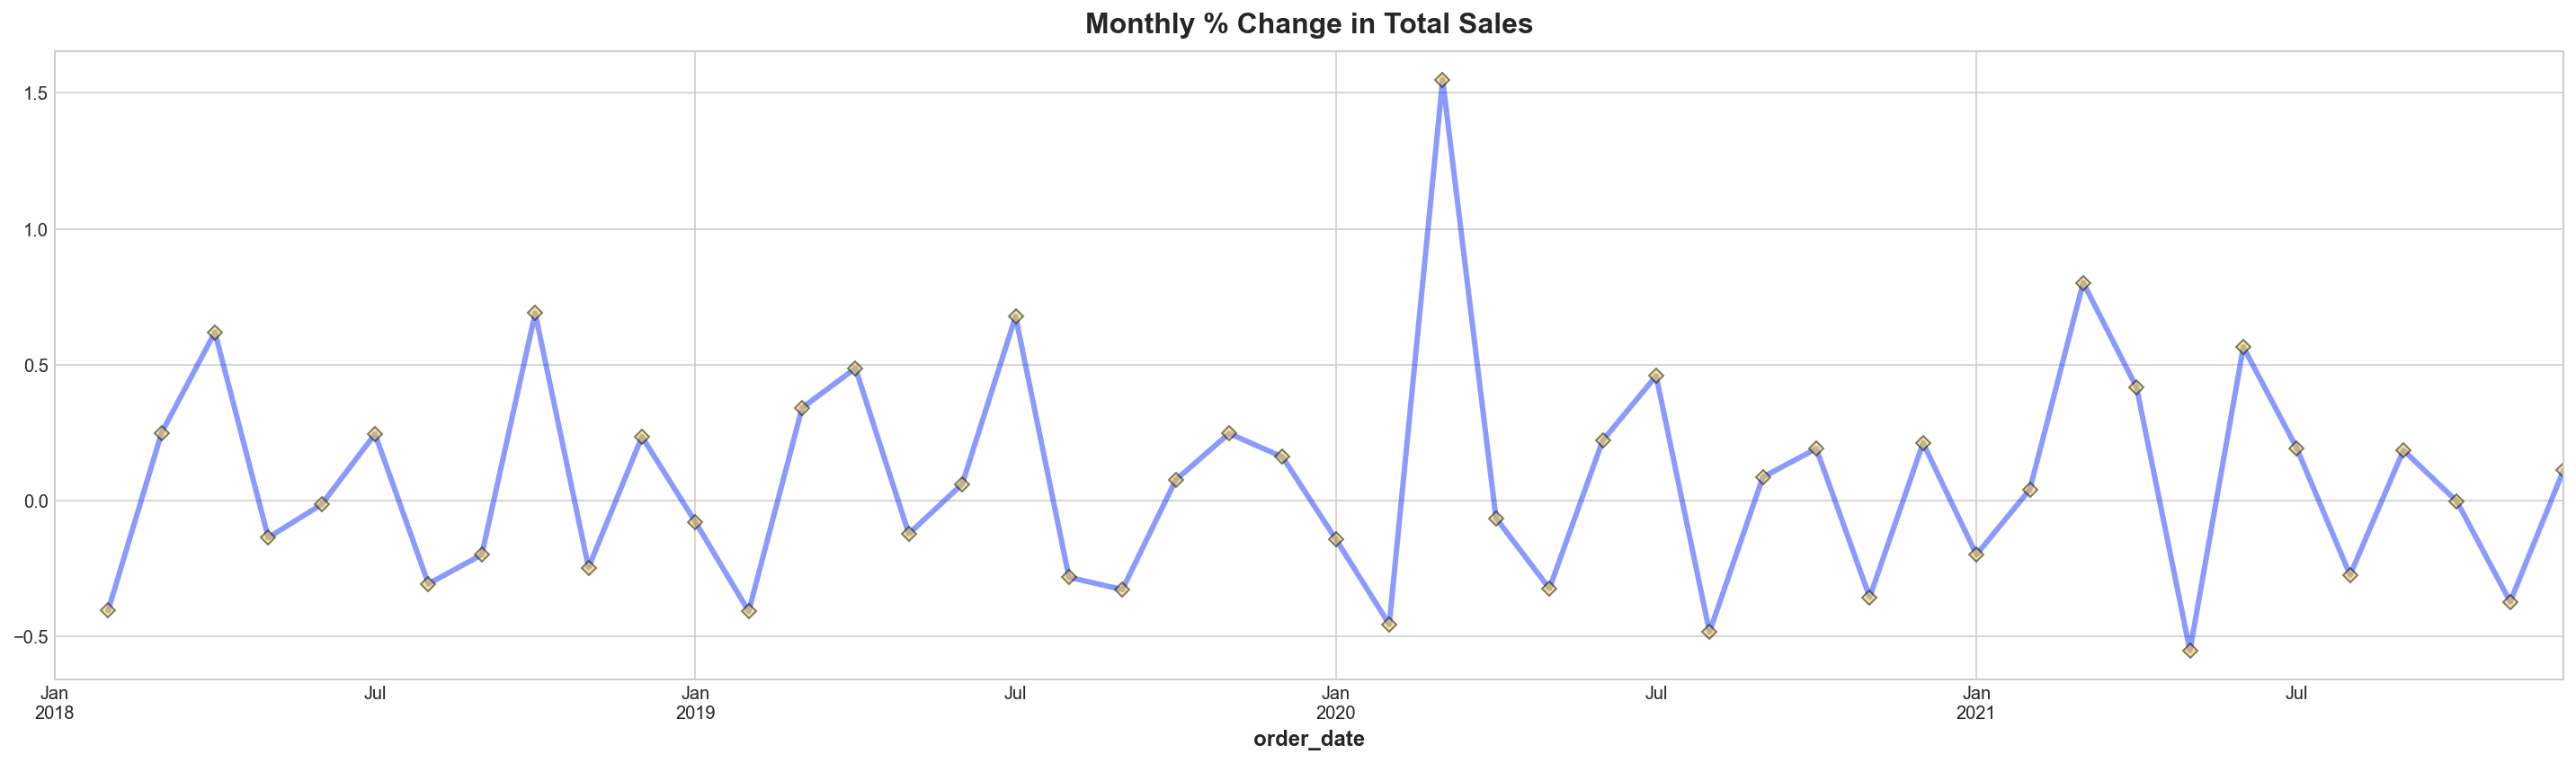

In [180]:
y_month = ts.resample('M').sum()
plt.figure(figsize = (20, 6))
(y_month.diff() / y_month.shift()).plot(alpha=.5, lw=3, c='#1a34ff', 
                                      marker='D', mfc='#f2cb30',mec='black', title='Monthly % Change in Total Sales');

#### Takeaway:
In the beginning of the pandemic there was a spike in sales.

In [192]:
cities = train.customer_city.unique().tolist()

In [209]:
cities_df = pd.DataFrame(columns = ['city', 'total_purchase_amount'])
for city in cities:
    #print(city)
    city_df = train[train.customer_city == city]
    city_amount = round(city_df.purchase_amount.sum(),2)
    #print(city_amount)
    cities_df.loc[len(cities_df)] = [city, city_amount]
    #display(cities_df)

In [210]:
cities_df.sort_values(by='total_purchase_amount', ascending=False).head(5)

,city,total_purchase_amount
2,Austin,"216,233,694.73"
7,San Antonio,"110,309,436.10"
23,Dallas,"71,774,803.24"
16,Houston,"62,532,487.16"
8,Fort Worth,"29,232,621.23"
